# 2D Tensile test - CompMod2
WITH MECHANICALTEST + ARGIOPE + COMPMOD2 + ABAQUS

In [1]:
%load_ext autoreload
%matplotlib nbagg
%autoreload 2

In [2]:
import MechanicalTest.model_traction as model
import os, subprocess, time, local_settings, time
import matplotlib.pyplot as plt
import matplotlib as mpl
import argiope as ag
import compmod2 as cp2
import numpy as np

#-------------------------------------------------------------------------------
# USEFUL FUNCTIONS
def create_dir(path):
  try:
    os.mkdir(path)
  except:
    pass
#-------------------------------------------------------------------------------


In [3]:
GMSH_PATH = 'gmsh'

SETTINGS

In [4]:
workdir   = "workdir/"
outputdir = "outputs/"
label   = "Trac"
template_dir = "TensileTest2D_full" 
#-------------------------------------------------------------------------------

create_dir(workdir)
create_dir(workdir + outputdir)

## MESH DEFINITIONS

In [5]:
def element_map(mesh):
    mesh.elements.loc[mesh.elements.type.argiope == "tri3", ("type", "solver", "")] = "CPE3" 
    mesh.elements.loc[mesh.elements.type.argiope == "quad4", ("type", "solver", "")] = "CPE4R" 
    return mesh
 

## Material and Sample definition using compmod

In [6]:
def material_map_comp(mesh):
    mesh.elements.materials = ["MAT{0}".format(i+1) for i in range(len(mesh.elements.index))]
    return mesh

parts = {
    "sample" :model.Sample2D_quarter(workdir = workdir,
                                   L = 30.,
                                   l = 10/3.,
                                   r = 5.,
                                   lcf = (10/3.)/30.,
                                   lcg = 3.,
                                   gmsh_path = GMSH_PATH,
                                   gmsh_space = 2, 
                                   gmsh_options = "-algo delquad",
                                   element_map = element_map,
                                   material_map = material_map_comp)}

# Make the mesh a first time to konw the number of elts
parts["sample"].make_mesh()    
Ne = parts["sample"].mesh.elements.shape[0]

# Material def using compmod
dist = cp2.distributions.Uniform()
xt, x = dist.discretize(Ne, xmax = 1.)
np.random.shuffle(x)

#homogeneous parameters
E= 100e3
nu=.3
yield_stress = 2000

One of the following cell must be activated:

In [7]:
# homogeneous Model
if False:
    materials = [ag.materials.ElasticPerfectlyPlastic(
                                     label = "MAT{0}".format(i+1), 
                                     young_modulus = E, 
                                     poisson_ratio = nu, 
                                     yield_stress =  yield_stress) 
                                     for i in range(Ne)]

In [8]:
# heterogeneous parameters : Yield Stress
if True:
    Delta_yield = 100 # MPa var on yield stress 
    materials = [ag.materials.ElasticPerfectlyPlastic(
                                     label = "MAT{0}".format(i+1), 
                                     young_modulus = E, 
                                     poisson_ratio = nu, 
                                     yield_stress = (Delta_yield*(x[i]-.5) + yield_stress)) 
                                     for i in range(Ne)]

In [9]:
# heterogeneous parameters : Youngs Modulus
if False:
    Delta_E = 20e3 # MPa var on E 
    materials = [ag.materials.ElasticPerfectlyPlastic(
                                     label = "MAT{0}".format(i+1), 
                                     young_modulus = (Delta_E*(x[i]-.5)) + E, 
                                     poisson_ratio = nu, 
                                     yield_stress = yield_stress)
                                     for i in range(Ne)]

In [10]:
# heterogeneous parameters : Poisson ratio
if False:
    Delta_nu = .1 #  var on Nu
    materials = [ag.materials.ElasticPerfectlyPlastic(
                                     label = "MAT{0}".format(i+1), 
                                     young_modulus =  E, 
                                     poisson_ratio = (Delta_nu*(x[i]-.5)) +nu, 
                                     yield_stress = yield_stress)
                                     for i in range(Ne)]

## STEP DEFINTIONS

In [14]:
steps = [
        model.Step2D_traction(name = "LOADING1",
                              kind = "adaptative",
                              control_type = "disp",
                              duration = 1.,
                              nframes = 10,
                              controlled_value = 2. ),
        ]             

TracModel = model.Traction2D(label = label, 
                      parts = parts, 
                      steps = steps, 
                      materials = materials, 
                      solver = "abaqus", 
                      solver_path = local_settings.ABAQUS_PATH,
                      workdir = workdir,
                      verbose = True)

TracModel.write_input()

<IPython.core.display.Javascript object>


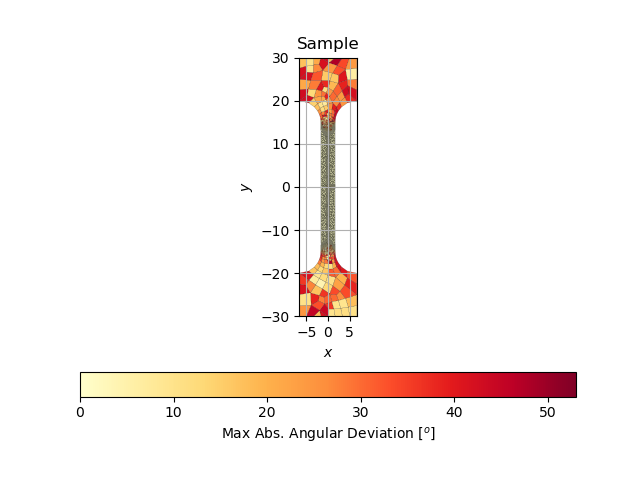

In [15]:
i = 1
fig = plt.figure()
parts_names = parts.keys()
for name, part in parts.items(): 
    mesh = part.mesh
    patches = mesh.to_polycollection(edgecolor = "black", linewidth = .1, alpha = 1.)
    stats = mesh.stats()
    patches.set_array( stats.stats.max_abs_angular_deviation )
    patches.set_cmap(mpl.cm.YlOrRd)
    ax = fig.add_subplot(1, 1, 1)
    ax.set_aspect("equal")
    ax.set_xlim(mesh.nodes.coords.x.min(), mesh.nodes.coords.x.max())
    ax.set_ylim(mesh.nodes.coords.y.min(), mesh.nodes.coords.y.max())
    #ax.set_xlim(-6, 6)
    #ax.set_ylim(-1,11)
    ax.add_collection(patches)
cbar = plt.colorbar(patches, orientation = "horizontal")
cbar.set_label("Max Abs. Angular Deviation [$^o$]")
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.grid()
plt.title(name.title())
    #i+= 1
plt.show()

## RUN

In [16]:
if True:
    TracModel.run_simulation()

#### RUNNING "Trac" USING SOLVER "ABAQUS"
     Analysis initiated from SIMULIA established products
     Abaqus JOB Trac
     Abaqus 3DEXPERIENCE R2018x
     Abaqus License Manager checked out the following licenses:
     Abaqus/Standard checked out 5 tokens from Flexnet server flex2-symme.univ-savoie.fr.
     <48 out of 90 licenses remain available>.
     Begin Analysis Input File Processor
     6/12/2019 11:20:43 AM
     Run pre.exe
     6/12/2019 11:21:19 AM
     End Analysis Input File Processor
     Begin Abaqus/Standard Analysis
     6/12/2019 11:21:19 AM
     Run standard.exe
     6/12/2019 11:22:39 AM
     Abaqus Error: Abaqus/Standard Analysis exited with an error - Please see the
     message file for possible error messages if the file exists.
     Begin Convert MFS to SFS
     6/12/2019 11:22:40 AM
     Run SMASimUtility.exe
     6/12/2019 11:22:40 AM
     End Convert MFS to SFS
     Abaqus/Analysis exited with errors
  => RAN Trac: DURATION = 127.00s


In [17]:
TracModel.postproc()
TracModel.save(workdir +label+ ".pcklz")

#### POST-PROCESSING "Trac" USING POST-PROCESSOR "ABAQUS"
     Abaqus License Manager checked out the following license(s):
     "cae" release 6.18 from flex2-symme.univ-savoie.fr
     <3 out of 9 licenses remain available>.
  => POST-PROCESSED Trac: DURATION = 143.43s >


## Re-load the case for post process

In [ ]:
TracModel = ag.utils.load(workdir +label+ ".pcklz")               

In [18]:
hist = TracModel.data["history"]
hist.head()  

RF  dtot    t  step           F
0    -0.00000   0.0  0.0     0    -0.00000
1  1667.59521   0.2  0.1     0  1667.59521
2  3323.45361   0.4  0.2     0  3323.45361
3  4967.68262   0.6  0.3     0  4967.68262
4  6600.38672   0.8  0.4     0  6600.38672

## Plots

<IPython.core.display.Javascript object>


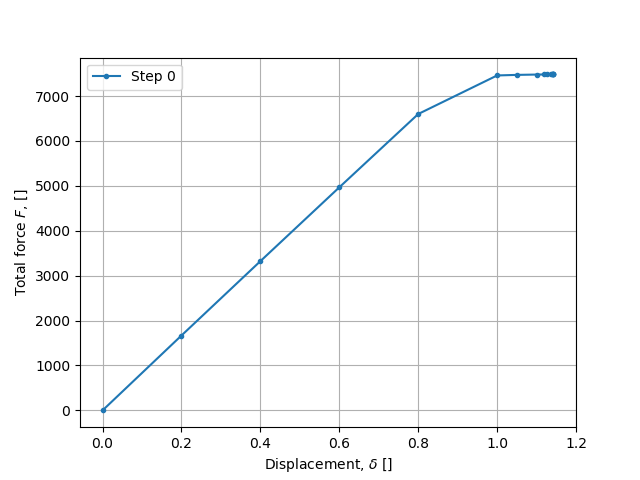

In [19]:
plt.figure()
for step, group in hist.groupby("step"):
  plt.plot(group.dtot, group.F,'.-', label = "Step {0}".format(step))
plt.grid()
plt.legend(loc = "best")
plt.ylabel("Total force $F$, []")
plt.xlabel("Displacement, $\delta$ []")
plt.show()

<IPython.core.display.Javascript object>


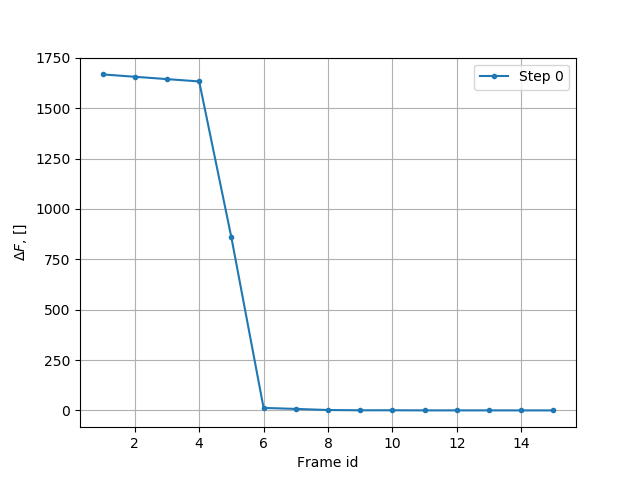

In [20]:
plt.figure()
for step, group in hist.groupby("step"):
  plt.plot(group.index, group.F.diff(),'.-', label = "Step {0}".format(step))
plt.grid()
plt.legend(loc = "best")
plt.ylabel("$\Delta F$, []")
plt.xlabel("Frame id")
plt.show()

In [21]:
meta=TracModel.parts["sample"].mesh.fields_metadata()

meta

frame frame_value label      part position step_label step_num
0     0           0    LE  I_SAMPLE     node   LOADING1        0
1     0           0    PE  I_SAMPLE     node   LOADING1        0
2     0           0     S  I_SAMPLE     node   LOADING1        0
3     0           0   Seq  I_SAMPLE     node   LOADING1        0
4     0           0     U  I_SAMPLE     node   LOADING1        0
5     1    0.571331    LE  I_SAMPLE     node   LOADING1        0
6     1    0.571331    PE  I_SAMPLE     node   LOADING1        0
7     1    0.571331     S  I_SAMPLE     node   LOADING1        0
8     1    0.571331   Seq  I_SAMPLE     node   LOADING1        0
9     1    0.571331     U  I_SAMPLE     node   LOADING1        0

<IPython.core.display.Javascript object>


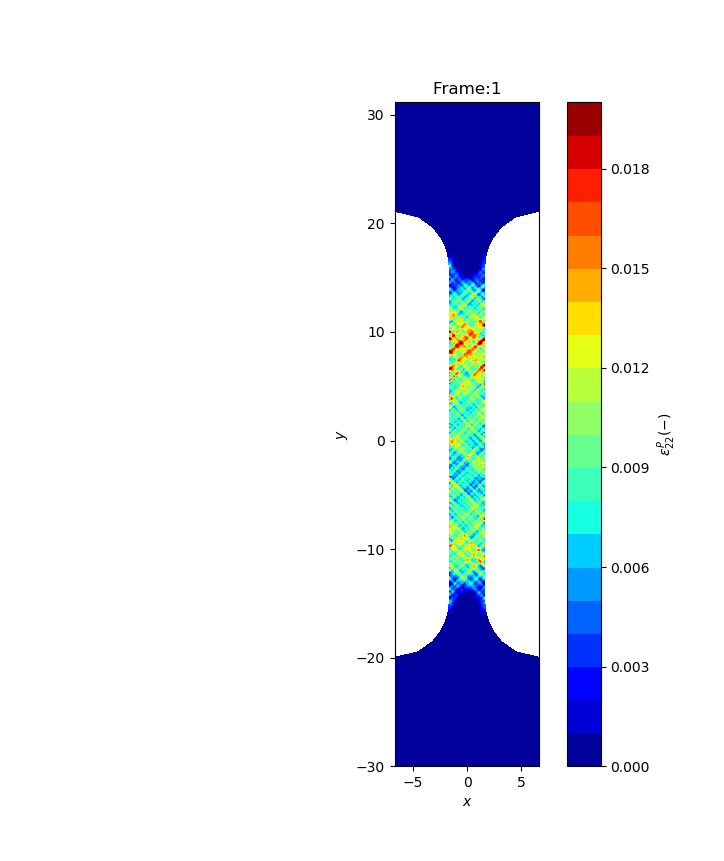

In [24]:
#Frame number to plot
frame_num=1
parts = {k:part.mesh.copy() for k, part in TracModel.parts.items() }

fig = plt.figure()
ax = fig.add_subplot(1,1,1)

field_num = meta[(meta.label=='PE') & (meta.frame==frame_num)].index[0]
disp_num  = meta[(meta.label=='U')  & (meta.frame==frame_num)].index[0]
levels = np.linspace(.0, 0.02, 21)
dispMagnification = 1.

for k, mesh in parts.items():
    
    field =mesh.fields[field_num].data.v22
    disp = mesh.fields[disp_num].data
    frame = mesh.fields[disp_num].frame
    mesh.nodes[("coords", "x")] += dispMagnification*disp.v1
    mesh.nodes[("coords", "y")] += dispMagnification*disp.v2
    tri = mesh.to_triangulation()
    patches = mesh.to_polycollection(facecolor = "none",edgecolor = "black",linewidth = .02) 
    ax.add_collection(patches)
    g=ax.tricontourf(tri, field, levels, cmap = mpl.cm.jet, alpha = 1)
    
    

plt.title("Frame:{0}".format(frame))
ax.set_aspect("equal")
#ax.set_xlim(0, 55.)
#ax.set_ylim(-40, 20.)
cbar = plt.colorbar(g)
cbar.set_label("$\epsilon^P_{22} (-)$")
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.show()